In [1]:
import sys
import os
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir))
# Add parent directory to sys.path
sys.path.insert(0, parent_dir)
# Now you can import the module

import gptransform
import torch
import matplotlib.pyplot as plt
from pickle import dump,load
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multivariate_normal import  MultivariateNormal

In [2]:
class data(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    if len(self.X) != len(self.Y):
      raise Exception("len(X) != len(Y)")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    _x = self.X[index].unsqueeze(dim=0)
    _y = self.Y[index].unsqueeze(dim=0)

    return _x, _y

def train_loop(dataloader, model, optimizer, totalEpochs, r_grid, q_train, sq_train, q_infer, r_infer, ylo_q, yhi_q, ylo_r, yhi_r):
    model.train()
    optimizer.zero_grad()
    losses = []
    tic = time.time()
    for epoch in range(totalEpochs):
        epoch_loss = 0
        for batch, (X, y) in enumerate(dataloader):
            # Compute prediction and loss
            loss = model.NEG_LMLH_Monte_Carlo(r_grid, X[0], y[0])
                
            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss.detach().item()

        losses.append(epoch_loss)
            
        if epoch % 10 == 0:
            toc = time.time()
            print(f"loss: {epoch_loss:>7f}  [{epoch:>5d}/{totalEpochs:>5d}]")
            model.print_params()
            print(f"Minutes Taken: {(toc - tic)/60:>4f} ")
            print()

            with torch.no_grad():

                plt.title("S(q) Prediction")
                μ_q, Σ_q = model.predict_sq_monte_carlo(r_grid, q_infer, q_train, sq_train,False)
                plt.scatter(q_train,sq_train,alpha=0.2,label="Presented Data")
                plt.plot(q_infer.detach().numpy(),μ_q.detach().numpy(),label="Mean Prediction")
                plt.fill_between(q_infer.T[0].detach().numpy(), μ_q.T[0].detach().numpy()+torch.diag(Σ_q).detach().numpy()**0.5, μ_q.T[0].detach().numpy()-torch.diag(Σ_q).detach().numpy()**0.5,alpha=0.5,label="1 +- std")
                plt.ylim(ylo_q,yhi_q)
                plt.xlim(q_infer[0],q_infer[-1])
                plt.legend()
                plt.show()
            
            tic = time.time()

    return losses

In [3]:
init_param_bounds = torch.zeros((8,2))

# Ell
init_param_bounds[0,1] = 2.5
init_param_bounds[0,0] = 0.1

# Max
init_param_bounds[1,1] = 2
init_param_bounds[1,0] = 0.2

# Slope
init_param_bounds[2,1] = 10
init_param_bounds[2,0] = 1

# Loc
init_param_bounds[3,1] = 6
init_param_bounds[3,0] = 0.5

# Decay
init_param_bounds[4,1] = 1
init_param_bounds[4,0] = 0.1

# Sigma_n
init_param_bounds[5,1] = 0.05
init_param_bounds[5,0] = 0.0001

# r_0
init_param_bounds[6,1] = 6
init_param_bounds[6,0] = 0.5

# s
init_param_bounds[7,1] = 50
init_param_bounds[7,0] = 0.1

init_params = torch.sum(init_param_bounds,dim=1)/2

init_params = torch.tensor([0.865067, 1.013347, 8.142989, 3.344472, 0.339833, 0.024758, 3.382172, 20.660809 ])

In [ ]:
dtype = torch.float

σOO = 0.0374
σOH = - 0.0964
σHH = 0.0622

σOHD = 0.0378
σHD = 0.0096

σOD = 0.1721 
σDD = 0.1978

M = torch.tensor([[σOO, σOH , σHH],
                  [σOO, σOHD, σHD],
                  [σOO, σOD , σDD]])


M_inv = torch.linalg.inv(M)

r_grid = torch.linspace(0.01, 20, 500)
every = 2
ditOH = 7
my_data = np.genfromtxt("../water_data_soper/NIMROD00000684.mint01", skip_header=14)#[::2]
q_h2o = torch.unsqueeze(torch.tensor(my_data.T[0][::every]),dim=1)[:-ditOH]
sq_HH = torch.unsqueeze(torch.tensor(my_data.T[1][::every]),dim=1)[:-ditOH]

my_data = np.genfromtxt("../water_data_soper/NIMROD00000687.mint01", skip_header=14)#[::2]
q_d2o = torch.unsqueeze(torch.tensor(my_data.T[0][::every]),dim=1)[:-ditOH]
sq_DD = torch.unsqueeze(torch.tensor(my_data.T[1][::every]),dim=1)[:-ditOH]

my_data = np.genfromtxt("../water_data_soper/NIMROD00000686.mint01", skip_header=14)#[::2]
q_hdo = torch.unsqueeze(torch.tensor(my_data.T[0][::every]),dim=1)[:-ditOH]
sq_HD = torch.unsqueeze(torch.tensor(my_data.T[1][::every]),dim=1)[:-ditOH]

q_train = q_hdo

r_grid = r_grid.reshape(-1,1)
q_train = q_train.reshape(-1,1)
sq_HH = sq_HH.reshape(-1,1)
sq_HD = sq_HD.reshape(-1,1)
sq_DD = sq_DD.reshape(-1,1)

sq_noisey_HH = (sq_HH)
sq_noisey_HD = (sq_HD)
sq_noisey_DD = (sq_DD)

structure_total_q_noisey = torch.zeros((3,len(q)))
structure_total_q_noisey[0] = sq_noisey_HH.T[0]
structure_total_q_noisey[1] = sq_noisey_HD.T[0]
structure_total_q_noisey[2] = sq_noisey_DD.T[0]
structure_partial_q_noisey = (M_inv @ structure_total_q_noisey)

partial_sq_noisey_OO = structure_partial_q_noisey[0].reshape(-1,1)
partial_sq_noisey_OH = structure_partial_q_noisey[1].reshape(-1,1)
partial_sq_noisey_HH = structure_partial_q_noisey[2].reshape(-1,1)

perm = torch.randperm(len(q_train))

# Put into Pytorch Dataloader
dataset_OO = data(q_train[perm].reshape(10,49,1),structure_partial_q_noisey[0][perm].reshape(10,49,1))
dataset_OH = data(q_train[perm].reshape(10,49,1),structure_partial_q_noisey[1][perm].reshape(10,49,1))
dataset_HH = data(q_train[perm].reshape(10,49,1),structure_partial_q_noisey[2][perm].reshape(10,49,1))

for batOH, (X, y) in enumerate(dataset_OO):
    # Compute prediction and loss
    plt.scatter(X[0], y[0],label="BatOH # " + str(batOH))
plt.plot(q_train,partial_sq_noisey_OO)
plt.ylim(-1.2,1.5)
#plt.legend()
plt.show()

for batOH, (X, y) in enumerate(dataset_OH):
    # Compute prediction and loss
    plt.scatter(X[0], y[0],label="BatOH # " + str(batOH))
plt.plot(q_train,partial_sq_noisey_OH)
plt.ylim(-1.2,2.5)
#plt.legend()
plt.show()

for batOH, (X, y) in enumerate(dataset_HH):
    # Compute prediction and loss
    plt.scatter(X[0], y[0],label="BatOH # " + str(batOH))
plt.plot(q_train,partial_sq_noisey_HH)
plt.ylim(-1.2,0.5)
#plt.legend()
plt.show()

In [5]:
gp = gptransform.GP(init_params,init_param_bounds,0,0.02125,200)
gp.print_params()

l:       0.865067 
max:     1.013347 
slope:   8.142989 
loc:     3.344472 
decay:   0.339833 
sigma_n: 0.024758 
r_0:     3.382172 
s:       20.660807 


loss: -516.451370  [    0/  100]
l:       0.785065 
max:     1.025668 
slope:   8.149798 
loc:     3.548782 
decay:   0.315380 
sigma_n: 0.024990 
r_0:     3.561276 
s:       20.713072 
Minutes Taken: 0.524220 



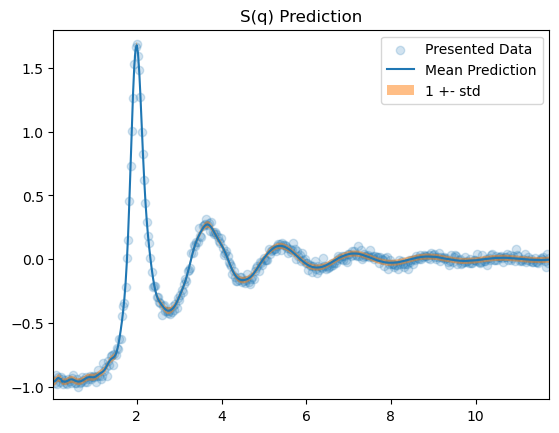

In [ ]:
optimizer = torch.optim.SGD(gp.parameters(), lr=0.0001, momentum=0.95)
train_loop(dataset, gp, optimizer, 100, r_grid, q_train, sq_train, q_infer, r_infer, -1.1,1.8, -0.1,3.1)

In [ ]:
with torch.no_grad():
    plt.title("S(q) Prediction")
    μ_q, Σ_q = gp.predict_sq_monte_carlo(r_grid, q_infer, q_train, sq_train)
    plt.scatter(q_train,sq_train,alpha=0.2,label="Presented Data")
    plt.plot(q_infer.detach().numpy(),μ_q.detach().numpy(),label="Mean Prediction")
    plt.fill_between(q_infer.T[0].detach().numpy(), μ_q.T[0].detach().numpy()+torch.diag(Σ_q).detach().numpy()**0.5, μ_q.T[0].detach().numpy()-torch.diag(Σ_q).detach().numpy()**0.5,alpha=0.5,label="1 +- std")
    plt.ylim(-1.1,1.8)
    plt.xlim(q_infer[0],q_infer[-1])
    plt.legend()
    plt.show()

In [ ]:
with torch.no_grad():
    plt.title("RDF Prediction")
    μ_r, Σ_r = gp.predict_rdf(r_grid, r_infer, q_train, sq_train)
    plt.plot(r_infer.detach().numpy(),μ_r.detach().numpy(),label="Mean Prediction")
    plt.fill_between(r_infer.T[0].detach().numpy(), μ_r.T[0].detach().numpy()+torch.diag(Σ_r).detach().numpy()**0.5, μ_r.T[0].detach().numpy()-torch.diag(Σ_r).detach().numpy()**0.5,alpha=0.5,label="1 +- std")
    plt.ylim(ylo_r,yhi_r)
    plt.xlim(r_infer[0],r_infer[-1])
    plt.legend()
    plt.show()